# K means

Goal of K means clustering is to group data into K clusters

It is often recommend to run K means several times to get the best clustering based on metrics such as Silhouette Score due to the choosing of random start centroids
- metrics: https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics.cluster


In [ ]:
import numpy as np
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): (K, n) centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """

    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly
    idx = np.zeros(X.shape[0], dtype=int)

    ### START CODE HERE ###
#     X[m,n]
    distance = []
    # for each centroid
    for centroid in centroids:
        # compute the distance to centroid for each input value
        distance.append(np.sqrt(((X[:,0]-centroid[0])**2) + ((X[:,1]-centroid[1])**2)))
        
    # distance.shape == (centroids,X)

    #convert to shape = (X,centroid)
    distance = np.stack(distance, axis=-1)
    
    # get index of the centroid who's distance is smallest for each X
    for i,s in enumerate(distance):
          idx[i] = np.argmin(s)
            
     ### END CODE HERE ###
    
    return idx

def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    # Useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly
    centroids = np.zeros((K, n))
    
    for k in range(K):
        # for each point that belongs to centroid k, find centroid of all those values 
        centroids[k] = np.mean(X[idx == k],axis=0)
        
    
    return centroids

def kmeans(X, K, max_iterations=100):
    m, n = X.shape
    # pick random data points to be our initial centroid
    centroids = X[np.random.choice(m, K, replace=False)]
    for _ in range(max_iterations):
        # for each data point compute the distance to all centroids and assign the point to the nearest one.
        idx = find_closest_centroids(X, centroids)
        # recompute each centroid for newly assigned labels
        new_centroids = compute_centroids(X, idx, K)
        if np.all(centroids == new_centroids):
            # Finish if converges
            # or max_iterations as been reached
            break
        centroids = new_centroids
    return centroids, idx

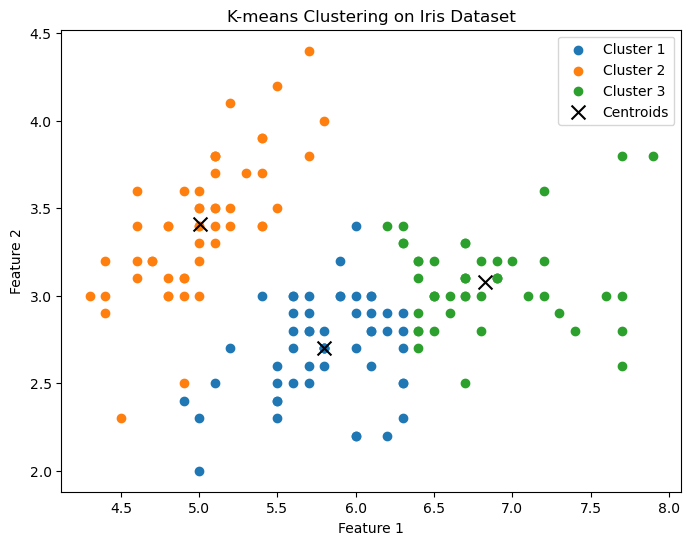

In [47]:
import numpy as np
from matplotlib import pyplot as plt


# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Set the number of clusters
K = 3

# Run K-means
centroids, idx = kmeans(X, K)

# Plot the results
plt.figure(figsize=(8, 6))
for k in range(K):
    cluster_points = X[idx == k]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k + 1}')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.title('K-means Clustering on Iris Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Anomaly Detection

Task of finding datapoint's that lie outside of the normal pattern of the data

Using the standard distributions of our data we see how many standard distributions each data point lies on for a given dimension

If it falls outside of a threshold value, the datapoint is marked as an anomaly
- If we already know that some datapoint are anomalies and others are not, it is possible to sweep many threshold values to find one that best separates normal and anonymous data
- use such metrics as F1 Score: https://en.wikipedia.org/wiki/F-score


Dimensions have to look like a standard disruption for this to work, it is possible to preform transformations on data to make it look like a normal disruption, though this is difficult to automate
- Only one of the dimensions for this data (dimension 1) seems to follow a normal distribution

6/150 are Anomalies


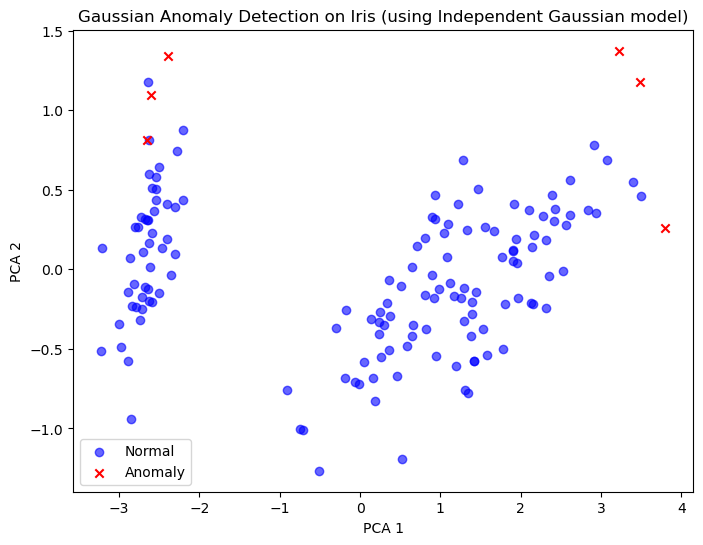

In [110]:
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X = iris.data
y = iris.target

# find mean and variance**2 of our dataset
mean = np.mean(X, axis=0)
variance_squared = np.var(X, axis=0)

#Find where each of out datapoint lies on normal distribution
def noraml_dist(X, mean, variance_squared):
    #https://en.wikipedia.org/wiki/Normal_distribution   

    exp = np.exp( -1 * (((X-mean)**2) / (2 * variance_squared)))
    coefficient = ( 1 / np.sqrt(2 * np.pi * variance_squared))
    return np.prod(coefficient * exp, axis=1)

p = noraml_dist(X, mean, variance_squared)

anomalies = p < 0.0005

print(f"{np.sum(anomalies)}/{len(X)} are Anomalies")

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[~anomalies, 0], X_2d[~anomalies, 1], c='blue', label='Normal', alpha=0.6)
plt.scatter(X_2d[anomalies, 0], X_2d[anomalies, 1], c='red', label='Anomaly', marker='x')
plt.title("Gaussian Anomaly Detection on Iris (using Independent Gaussian model)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()


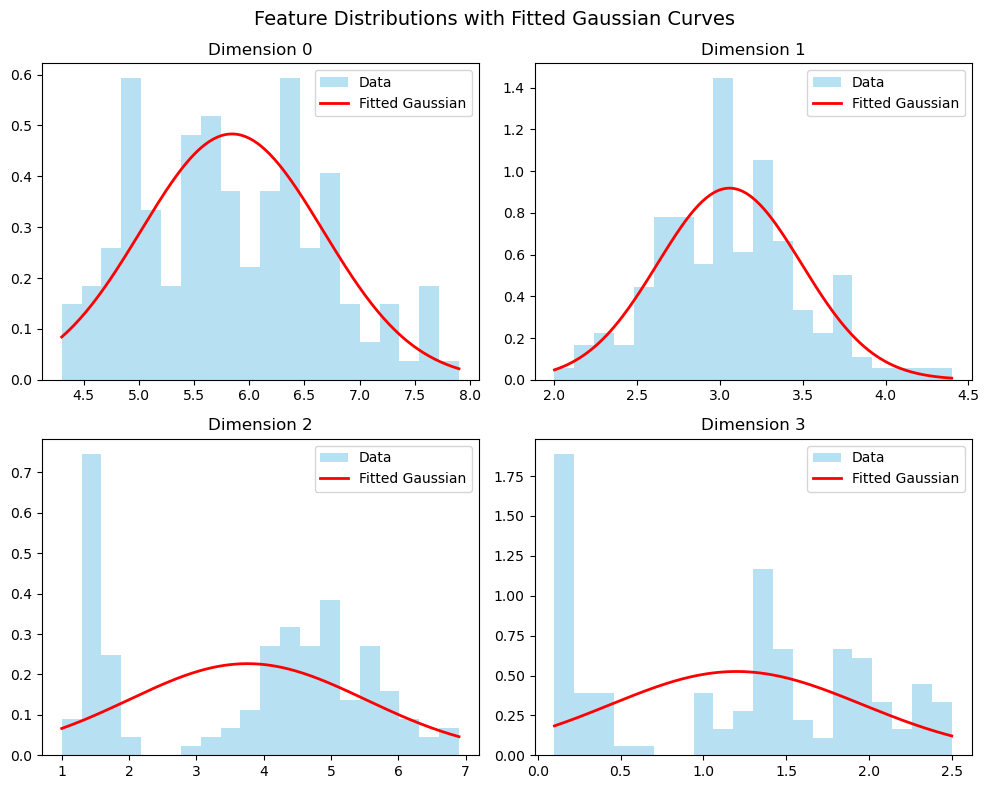

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    ax.hist(X[:, i], bins=20, density=True, alpha=0.6, color='skyblue', label='Data')

    # Plot fitted Gaussian curve
    x_vals = np.linspace(X[:, i].min(), X[:, i].max(), 200)
    pdf = (1 / np.sqrt(2 * np.pi * variance_squared[i])) * np.exp(
        -((x_vals - mean[i]) ** 2) / (2 * variance_squared[i])
    )
    ax.plot(x_vals, pdf, color='red', lw=2, label='Fitted Gaussian')

    ax.set_title(f"Dimension {i}")
    ax.legend()

plt.suptitle("Feature Distributions with Fitted Gaussian Curves", fontsize=14)
plt.tight_layout()
plt.show()

# recommender systems

to predict user's rating for something they have yet to rated :

The goal is to predict what a user would rate an item

for every user train linear regression model on every item they have ranked, input is item features and output is their predicted ranking


# Collaborative filtering algorithm

what if we don't know or don't have explicit features for items?: have features be a tunable parameter where loss takes J(x,w,b)


**parameter vector**(w) that embodies the learned tastes of a user ( plus **bias** (b)). For each item, a **feature vector**(x) of the same size which embodies some learned description of the item.

thus to get a prediction of what the user likes : np.dot(w,x) + b , where w are tastes of user, and x is the learned description of item we are trying to predict users taste of

Users will have some items unrated, keep track of this in matrix **R**(num_items,num_users) where 1 means item as been rated by user, and 0 means it has not (binary value indicator)

Users ratings are stored in matrix **Y** (num_items,num_users) with value of 1 to highest_possible_rating, with 0 meaning user has not rated item

Thus our final prediction_rating for item i for user j will be

```python
prediction_rating = (np.dot(w[j],x[i]) + b[j])

prediction_used_in_loss = R[i,j]*(np.dot(w[j],x[i]) + b[j])
```

When R[i,j] is 0 (user has not rated move) the prediction will always be zero, matching format of **Y**. This is useful as it causes Loss to be zero, thus during training, items unrated will have a gradient of 0 and not impact model training

We can devise loss function to train x,w,b

```python

predicted = X @ W.T + b
J = 0.5 * np.sum((R * predicted - Y)**2)
reg = (np.sum(np.square(W)) + np.sum(np.square(X)))  * (lambda_/2)

Loss = J + reg
```


Regularization is important here as we are taking the sum, not the average, X and W could grow to be very large

there can also be 2 bias terms for user's preferred features, and items features


# Collaborative Filtering
recommend items to users based on users who give similar ratings to other items as you

The higher rating a system predicts you would give and item, the more it user will be recommended item

# Content Filtering

Collaborative filtering recommends items based on the preferences of similar users, while content-based filtering recommends items similar to what a user has liked in the past based on item attributes

recommends items to users based on users features

relies on known features of a movie (year,average_rating,genre, etc.) and known features of a user (age, gender, movies_watched, etc.)

Target data is the rating a user has given to an item

use user features to compute feature vector for user and use item features to compute a feature vector for item

these 2 feature vectors much have the same final shape

to make prediction on how much the user will like the item take dot product of user and item vector

2 deep learning neural nets, one for user_vector and another for feature_vector

user_features -> deep_learning_model -> user_vector 

item_features -> deep_learning_model -> item_vector 

for only features that have been rated **R** matrix

```python
assert user_vector.shape == item_vector.shape, "shapes must match"
prediction = np.dot(user_vector,item_vector)
Loss = np.sum((prediction * R - y) ** 2)
```


can find how similar 2 items are by squared distance:  `np.sum((item1 - item2)**2)` for both Content Filtering, and Collaborative Filtering. or other distance metrics

### optimizing for large dataset

Retrieval & Ranking: Get Subset of items, a large list of possible recommendations

Retrieval example:
- find 10 most similar movies for each of the 10 last movies watched
- get top 20 in country
- get 10 from most view genre

Combine all retrieved items (no duplicates) and then fine tune the selection using more computational intense filtering

After 1,000,000 items have been slimed down to 1,000 items in Retrial set, can do more accurate ranking step such as running Content Filtering deep learning model ( can cache result of item_vector for all users, thus on a single search only the user_vector has to be computed)

### Ethical concerns

- can greatly benefit users and businesses
- many businesses optimize for profit instead of user experience
- Advertizement based recommenders can create harmful feedback loops, promoting exploitative businesses like payday lenders that can bid more for ads.
- engagement focused systems can unintentionally amplify harmful content
- recommender systems should be design to be transparent

# PCA

Reduce dimensions of data while trying to preserve relationship between data points

Used for visualization, reduce 500 features to 2 features so can plot on scatter plot

features are normalized first

If multiple axis are captures, all axis will be orthogonal to each outer

algorithm works by finding the axis(s) that have the most variance when the data is projected on said axis(s)

Attempts to reduce the amount of axis used to represent the data

Reconstruction: doing PCA losses information but its possible to approximate the original data using the recorded axis(s) and reduced datapoint

[4.22824171 0.24267075]
[0.92461872 0.05306648]


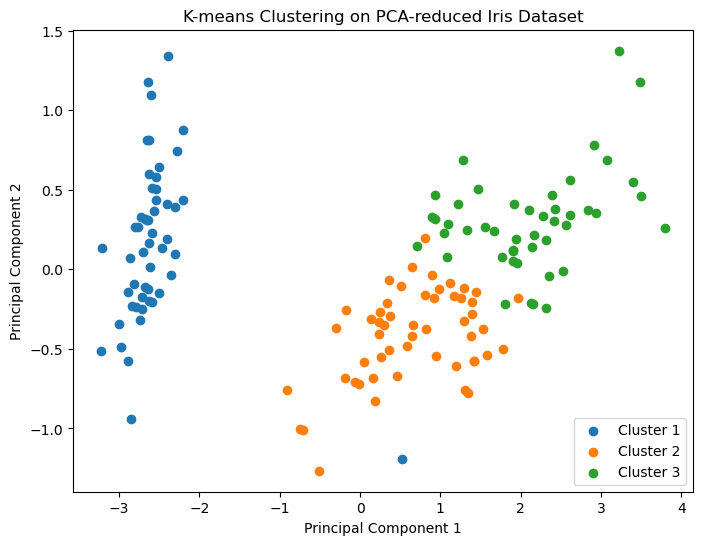

In [79]:
# use our K-means algorithm on unreduced dataset and see how it maps to PCA reduced dataset

import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

iris = datasets.load_iris()
X = iris.data  
y = iris.target

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

centroids, idx = kmeans(X, 3)


plt.figure(figsize=(8, 6))
for k in range(K):
    cluster_points = X_pca[idx == k]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k + 1}')

plt.title('K-means Clustering on PCA-reduced Iris Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# Reinforcement Learning
In reinforcement learning, an agent moves through states by taking actions and receives rewards based on those actions.

The goal of an agent is to maximize return

example: choosing between picking up $5 now or walking 30 minutes for $10 later.

The optimal policy is the one that maximizes expected return from each state.

Return : sum of rewards system has achieved but weighted by the discount factor: = R1 + (R2 * y) + (R3 * y^2) + (R4 * y^4)

Discount factor : controls how much future rewards matter. the longer it takes to get reward, the less it matters

State : description of the current situation the agent is in (state of chess board)

Action : a choice the agent can make at a given state

Reward : how "good" an action is

Policy: learned action of model at a given state to maximize the reward

Markov Decision Process : Future only depends on current state, not previous actions


## State–Action Value Function

Q(s,a) Returns expected reward if:
- you start in state s
- take action a once
- then act optimally afterwards

Once Q(s,a) is known, the optimal action for each state is whichever action returns the highest value 

Knowing Q(s,a) lets an agent choose the optimal action


## Bellman Equation

How to find Q(s,a)

R(s) : Reward of current state

s' : state after preforming action a in state s,

a' : action that you take in state s'

Q(s,a) = R(s) + gamma * max(Q(s',a'))

Recursive way to find Q(s,a): dynamic programming approach to exploring all possible states and actions an agent can take in a system

terminal state : state where there no further actions

## Continuous state spaces

State is rarely a discrete value, most time a vector such as : [x_pos,y_pos,x_vel,y_vel]

To approximate Q(s,a) train deep learning ann

input is our state vector and possible actions (1 hot encoded)

output/target value is expected reward for given state and action

Create a dataset of many states and actions and their reward by taking actions randomly, recording current state (s), action (a), Reward of current state ( R(s) ), and state after preforming action a (s') giving us (a,s,R(s),s')

R(s) and s' is enough to calculate Bellman Equation for our training target value 

Training Loop
- Take random actions in simulation to get 1000 (a,s,R(s),s')
- Use those 1000 samples to train model

in ANN training:
- X = (s,a)
- Y = R(s) + gamma *max (Q (s',a'))
- Q(s',a') in Bellman Equation is our ANN, initially initialized to random weights
- Every epoch set Q(s'a') to current ANN weights

It is more efficient for a ANN to just take the state, and output the reward for each of the possible actions, thus you would take the output with the highest value as your best action

## Epsilon Greedy Policy
during data collection:
- Most times take action that maximizes our Q(S,A) 95% of time. Greedy, learned best action
- 5% of time pick random action (exploration step)

Epsilon Greedy : % of time a random action is taken

exploration step case allows us to explore actions that learned policy has considered to be bad actions, but could prove to be good actions

Picking actions randomly -> exploration step

During training loop, gradually decrees e-greedy value: First explore by taking random actions, then toward end of training focus in on picking best actions from learned policy

# Mini batch optimiziation

For a single iteration, train model on subset of our training data, computing loss for just this subset which the weights are tuned on
- Reduces memory usage
- Increases learning speed, have to only run 1000 samples instead of 1,000,000 is faster
- a too small subset may lessen performance
- Helps escape local minimas 